# Задание 1
1. Проведите предобработку текстов из файлов positive.csv, negative.csv. Нужно выполнить те же действия, что в предыдущем дне, но не удалять редко встречающиеся слова. Регулировать использование редких слов будем на уровне модели word2vec. Не забудьте удалить стоп-слова.
2. Будем исследовать то, как влияют на качество преобразования *размер целевого векторного пространства* и *использование редких слов*. Создайте несколько моделей word2vec, перебрав параметры:
  - размер результирующего пространства: [10, 300, 500] при фиксированной минимальной встречаемости слов = 10
  - минимальная встречаемость слов: [1, 10, 100] при фиксированном размере результирующего векторного пространства = 300

  Обучите их на всем пространстве текстов.

3. Отберите 5 случайных слов из выборки позитивных публикаций и 5 случайных слови из выборки негативных публикаций.
4. Для каждой из обученных моделей найдите по 15 синонимов и по 15 антонимов для каждого из слов из п.3. Опишите:
  - как влияет размер результирующего пространства на точность определения синонимов/антонимов моделью? почему?
  - как влияет минимальная встречаемость слов на точность определения синонимов/антонимов моделью? почему?
5. Постройте графики распределения слов в двумерном пространстве. Опишите, как влияют исследуемые параметры на кучность и расположение точек на графике. Почему?
6. Возьмите любой твит, обучите модель word2vec с параметрами по умолчанию и попробуйте предсказать продолжение твита. Также попробуйте предсказать продолжение случайной фразы. Сравните результаты, полученные после обучения моделей с разным количеством эпох обучения.

# 1. Анализ текстов с использованием метода Word2vec

Word2vec - это еще один агоритм преобразования текстов в точки в векторном пространстве признаков. В его основе лежит нейронная сеть - автоэнкодер, который преобразует слово в вектор фиксированной длины. Особенность этого алгоритма заключается в том, что он учитывает семантику слов. Близкие по смыслу слова будут располагаться ближе друг к другу в векторном пространстве, а далекие - дальше. Если объем текстов достаточно большой, то с помощью модели word2vec мы можем определять синонимы и антонимы слов, и, благодаря этому, точность классификации текстов может увеличиться.

Сегодня будем пользоваться теми же наборами текстов, что и в прошлый раз. Прежде всего установим уже известные вам библиотеки для работы с текстовыми данными.


In [73]:
!pip install pymorphy2 nltk
import nltk
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import Image, display
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import pylab as pl
import re
import codecs
!pip install pymorphy2    #
import pymorphy2
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
%pylab inline
pylab.rcParams['figure.figsize'] = (15,10)
import re                 #
import csv                #
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Сейчас мы готовы к проведению предобработки текста. Но для того, чтобы работать с моделью word2vec, нам еще понадобится установить библиотеку gensim, в которой описана эта модель.

In [75]:
!pip install gensim

Для демонстрации возможностей этой библиотеки снова возьмем набор данных с текстами твитов, где сразу же переименуем класс -1 в 0. Вспомним, как выглядит наш датасет.

In [76]:
from google.colab import drive
import os
# drive.mount('/content/drive/')
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [77]:
# import pandas as pd

col_names = ['id', 'date', 'name', 'text', 'positive', 'rep', 'rtv', 'fav', 'total_count', 'fol', 'friends', 'list_count']
df_pos = pd.read_csv('/content/drive/MyDrive/school21/day06/datasets/positive.csv', sep=';',  comment='#', header=None, names=col_names)
df_neg = pd.read_csv('/content/drive/MyDrive/school21/day06/datasets/negative.csv', sep=';',  comment='#', header=None, names=col_names)
# dp = pd.read_csv('../datasets/positive.csv', sep=';', comment='#', header=None, names=names_c)
# dn = pd.read_csv('../datasets/negative.csv', sep=';', comment='#', header=None, names=names_c) 


# df.positive[df.positive==-1] = 0
# df.loc[16:25]

In [78]:
df_pos.shape

(114911, 12)

In [79]:
df_neg.shape

(111923, 12)

In [80]:
df = pd.concat([df_pos, df_neg], axis=0, ignore_index=True)

In [81]:
df.shape

(226834, 12)

In [82]:
df.positive[df.positive == -1] = 0

Сохраним объединенный датафрейм в таблицу excel.

In [83]:
nik_name = 'rriddler'
df.to_excel('/content/drive/MyDrive/school21/day06/datasets_'+nik_name+'.xlsx', index=False)

Так же, как и при использовании изученных раньше алгоритмов векторизации текста, нам нужно провести очистку данных, т.е. привести все слова текстов к одинаковому виду и форме. Напишем для этого функцию, чтобы можно было потом все эти действия вызывать одной командой.

In [84]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2


morph = pymorphy2.MorphAnalyzer()


def text_preprocessing(text):
    """Функция принимает строку и возвращает список слов в начальной форме"""
    text = text.lower()                                                         # приводим текст к нижнему регистру
    text = re.sub(r"[^А-Яа-я]", " ", text)                                      # удаляем все некириллические символы
    words = word_tokenize(text)                                                 # разбиваем тексты на списки слов
    words = [morph.parse(word)[0].normal_form for word in words]                # приводим слова к начальной форме
    words = [word for word in words if word not in stopwords.words("russian")]  # удаляем слова из стоп-листа
    return words

In [85]:
preprocessed_df = df[["text", "positive"]]
preprocessed_df.text = df.text.apply(text_preprocessing)
# preprocessed_df[15:25]

In [86]:
# preprocessed_df.to_excel('/content/drive/MyDrive/school21/day06/preprocessed_'+nik_name+'.xlsx', index=False)

In [87]:
# preprocessed_df = pd.read_excel('/content/drive/MyDrive/school21/day06/preprocessed_rriddler.xlsx')

In [88]:
preprocessed_df.to_pickle('/content/drive/MyDrive/school21/day06/preprocessed_'+nik_name+'.pkl')

In [89]:
# preprocessed_df = pd.read_pickle('/content/drive/MyDrive/school21/day06/preprocessed_rriddler.pkl')

In [143]:
from gensim.models import Word2Vec

w2v = Word2Vec(size=10, min_count=10)  # создадим экземпляр модели word2vec. Здесь size - размер векторного пространства,
                                       # min_count - минимальное количество появлений слова в наборе данных, при котором
                                       # будем учитывать это слово в модели
# w2v.save("/content/drive/MyDrive/school21/day06/1.model")
w2v.build_vocab(preprocessed_df.text)  # обучим модель на нашем наборе текстов
w2v.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=100) # обучим модель на нашем наборе текстов
w2v.save("/content/drive/MyDrive/school21/day06/1.model")

In [144]:
w2v300 = Word2Vec(size=300, min_count=10)  # создадим экземпляр модели word2vec. Здесь size - размер векторного пространства,
                                       # min_count - минимальное количество появлений слова в наборе данных, при котором
                                       # будем учитывать это слово в модели
w2v300.build_vocab(preprocessed_df.text)  # обучим модель на нашем наборе текстов
w2v300.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=100) # обучим модель на нашем наборе текстов
w2v300.save("/content/drive/MyDrive/school21/day06/2.model")

In [145]:
w2v500 = Word2Vec(size=500, min_count=10)  # создадим экземпляр модели word2vec. Здесь size - размер векторного пространства,
                                       # min_count - минимальное количество появлений слова в наборе данных, при котором
                                       # будем учитывать это слово в модели
w2v500.build_vocab(preprocessed_df.text)  # обучим модель на нашем наборе текстов
w2v500.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=100) # обучим модель на нашем наборе текстов
w2v500.save("/content/drive/MyDrive/school21/day06/3.model")

In [146]:
w2v300_1 = Word2Vec(size=300, min_count=1)  # создадим экземпляр модели word2vec. Здесь size - размер векторного пространства,
                                       # min_count - минимальное количество появлений слова в наборе данных, при котором
                                       # будем учитывать это слово в модели
w2v300_1.build_vocab(preprocessed_df.text)  # обучим модель на нашем наборе текстов
w2v300_1.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=100) # обучим модель на нашем наборе текстов
w2v300_1.save("/content/drive/MyDrive/school21/day06/4.model")

In [149]:
w2v300_100 = Word2Vec(size=300, min_count=100)  # создадим экземпляр модели word2vec. Здесь size - размер векторного пространства,
                                       # min_count - минимальное количество появлений слова в наборе данных, при котором
                                       # будем учитывать это слово в модели
w2v300_100.build_vocab(preprocessed_df.text)  # обучим модель на нашем наборе текстов
w2v300_100.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=100) # обучим модель на нашем наборе текстов
w2v300_100.save("/content/drive/MyDrive/school21/day06/5.model")

In [96]:
# w2v.wv.key_to_index
# w2v.wv.index2word
# w2v.wv.index_to_key

In [201]:
# pos_w = ['любимый', 'спасибо', 'праздник', 'мама', 'солнце']
pos_w = [['любимый'], ['спасибо'], ['праздник'], ['мама'], ['солнце']]
neg_w = [['зима'], ['больница'], ['голова'], ['зуб'], ['скучать']]

In [169]:
model_list = [w2v, w2v300, w2v500, w2v300_1, w2v300_100]
model_name = ["w2v", "w2v300", "w2v500", "w2v300_1", "w2v300_100"]
topn = 15


def synonyms_antonyms(list_word):
    for j in range(len(list_word)):
        print("Синонимы и антонимы для слова \"", list_word[j], "\"", sep='')
        print("Синонимы: ")
        for i in range(len(model_list)):
            try:
                synonyms = model_list[i].wv.most_similar(positive=list_word[j], topn=topn)
                word = []
                for k in range(topn):
                    word.append(synonyms[k][0])
            except:
                word = ['Key not present']
            print("     модель ", str(model_name[i]), ":", word, sep='')
        print("Антонимы: ")
        for i in range(len(model_list)):
            try:
                antonyms = model_list[i].wv.most_similar(negative=list_word[j], topn=topn)
                word = []
                for k in range(topn):
                    word.append(antonyms[k][0])
            except:
                word = ['Key not present']
            print("     модель ", str(model_name[i]), ":", word, sep='')
        print("------------------------------------------------------------------------------------------------------------------------------")    


synonyms_antonyms(pos_w)
synonyms_antonyms(neg_w)

Синонимы и антонимы для слова "['любимый']"
Синонимы: 
     модель w2v:['обожать', 'скучать', 'священный', 'андрей', 'родник', 'распасться', 'встретить', 'танго', 'кач', 'встречать', 'лагер', 'вальс', 'весёлый', 'океан', 'беззаботный']
     модель w2v300:['любить', 'хороший', 'родный', 'друг', 'скучать', 'милый', 'прекрасный', 'замечательный', 'весь', 'дорогой', 'безумно', 'классный', 'который', 'рада', 'хотеть']
     модель w2v500:['любить', 'хороший', 'друг', 'скучать', 'хотеть', 'весь', 'сегодня', 'очень', 'который', 'день', 'родный', 'прекрасный', 'спасибо', 'милый', 'свой']
     модель w2v300_1:['любить', 'хороший', 'весь', 'хотеть', 'очень', 'день', 'это', 'друг', 'сегодня', 'ещё', 'всё', 'который', 'знать', 'мочь', 'свой']
     модель w2v300_100:['родный', 'скучать', 'любить', 'прекрасный', 'милый', 'замечательный', 'хороший', 'дорогой', 'обожать', 'душевный', 'безумно', 'солнышко', 'шикарный', 'счастливый', 'чудесный']
Антонимы: 
     модель w2v:['патрон', 'балин', 'хны', 'доно

In [170]:
def synonyms(word):
  s = ["size=10, min_count=10"]
  for j in range(15):
    s.append(w2v.wv.most_similar(positive=word, topn=15)[j])
  df_syn = pd.DataFrame(s)
  s2 = ["size=300, min_count=10"]
  for j in range(15):
    s2.append(w2v300.wv.most_similar(positive=word, topn=15)[j])
  df_syn["1"] = s2
  s3 = ["size=500, min_count=10"]
  for j in range(15):
    s3.append(w2v500.wv.most_similar(positive=word, topn=15)[j])
  df_syn["2"] = s3
  s4 = ["size=300, min_count=1"]
  for j in range(15):
    s4.append(w2v300_1.wv.most_similar(positive=word, topn=15)[j])
  df_syn["3"] = s4
  s5 = ["size=300, min_count=100"]
  for j in range(15):
    s5.append(w2v300_100.wv.most_similar(positive=word, topn=15)[j])
  df_syn["4"] = s5
  print("Синонимы слова", word)
  print(df_syn)
  print("------------------\n")


In [171]:
for word in pos_w:
  synonyms(word)

Синонимы слова ['любимый']
                                    0                                     1  \
0               size=10, min_count=10                size=300, min_count=10   
1       (обожать, 0.8718013167381287)          (любить, 0.4816038906574249)   
2        (скучать, 0.871781587600708)         (хороший, 0.4407423138618469)   
3     (священный, 0.8657561540603638)          (родный, 0.3976309597492218)   
4        (андрей, 0.8532636165618896)            (друг, 0.3804047703742981)   
5        (родник, 0.8444536924362183)          (скучать, 0.369324266910553)   
6     (распасться, 0.843974232673645)           (милый, 0.3509323000907898)   
7     (встретить, 0.8403834104537964)      (прекрасный, 0.3419240713119507)   
8         (танго, 0.8393110036849976)  (замечательный, 0.33900243043899536)   
9           (кач, 0.8384708762168884)            (весь, 0.3375067710876465)   
10    (встречать, 0.8381063342094421)         (дорогой, 0.3280640244483948)   
11        (лагер, 0.83719

In [172]:
for word in neg_w:
  synonyms(word)

Синонимы слова ['зима']
                                  0                                     1  \
0             size=10, min_count=10                size=300, min_count=10   
1      (погода, 0.9495091438293457)           (снег, 0.39389166235923767)   
2     (погодка, 0.9389481544494629)          (весна, 0.38904404640197754)   
3       (зимой, 0.9384858012199402)          (погода, 0.3861643075942993)   
4        (снег, 0.9297302961349487)           (зимой, 0.3682774305343628)   
5        (сыро, 0.9275831580162048)          (зимний, 0.3435947299003601)   
6   (дождливый, 0.9220533967018127)            (лето, 0.3214431703090668)   
7       (весна, 0.9215931296348572)           (осень, 0.2958217263221741)   
8     (слетать, 0.9057576656341553)         (зимушка, 0.2931712865829468)   
9      (ливень, 0.9050226211547852)          (дождь, 0.28978094458580017)   
10       (жара, 0.8972522020339966)          (улица, 0.28648239374160767)   
11     (солнце, 0.8902847170829773)        (морозец,

Аналогично можем посмотреть наименее похожие слова:

In [177]:
def antonyms(word):
  s = ["size=10, min_count=10"]
  for j in range(0,5):
    s.append(w2v.wv.most_similar(negative=word, topn=15)[j])
  df_ant = pd.DataFrame(s)
  s2 = ["size=300, min_count=10"]
  for j in range(0,5):
    s2.append(w2v300.wv.most_similar(negative=word, topn=15)[j])
  df_ant["1"] = s2
  s3 = ["size=500, min_count=10"]
  for j in range(0,5):
    s3.append(w2v500.wv.most_similar(negative=word, topn=15)[j])
  df_ant["2"] = s3
  s4 = ["size=300, min_count=1"]
  for j in range(0,5):
    s4.append(w2v300_1.wv.most_similar(negative=word, topn=15)[j])
  df_ant["3"] = s4
  s5 = ["size=300, min_count=100"]
  for j in range(0,5):
    s5.append(w2v300_100.wv.most_similar(negative=word, topn=15)[j])
  df_ant["4"] = s5
  print(" Антонимы слова", word)
  print(df_ant)
  print("------------------\n")

In [178]:
for word in pos_w:
  antonyms(word)

 Антонимы слова ['любимый']
                                 0                                1  \
0            size=10, min_count=10           size=300, min_count=10   
1     (патрон, 0.9064071774482727)        (цэг, 0.4032064378261566)   
2      (балин, 0.8869946002960205)   (дараарай, 0.4023040533065796)   
3        (хны, 0.8865652084350586)      (хогын, 0.3936861455440521)   
4      (донор, 0.8810856342315674)  (гаровать, 0.39341968297958374)   
5  (виртуалка, 0.8750225305557251)    (нялхас, 0.39150112867355347)   

                                  2                                    3  \
0            size=500, min_count=10                size=300, min_count=1   
1   (дараарай, 0.34171760082244873)    (неподетски, 0.30757004022598267)   
2    (гаровать, 0.3414144515991211)   (растеряться, 0.28808480501174927)   
3  (тохиолдох, 0.33947131037712097)  (аэроэкспресс, 0.28767651319503784)   
4     (нялхас, 0.33641403913497925)         (сокет, 0.28649359941482544)   
5         (цэг, 0.

In [166]:
for word in neg_w:
  antonyms(word)

 Антонимы слова ['зима']
                               0                                  1  \
0          size=10, min_count=10             size=300, min_count=10   
1     (прод, 0.8824262619018555)  (освободить, 0.27748724818229675)   
2   (гуголь, 0.8777713179588318)    (лайкомер, 0.26437121629714966)   
3       (еа, 0.8764391541481018)    (васильев, 0.26305150985717773)   
4   (тереть, 0.8720748424530029)        (долбо, 0.2530386745929718)   
5  (фанатик, 0.8711841106414795)       (прина, 0.25000065565109253)   

                                   2                                  3  \
0             size=500, min_count=10              size=300, min_count=1   
1      (воронин, 0.2215944528579712)  (освободить, 0.28576576709747314)   
2    (лайкомер, 0.21632233262062073)        (пусся, 0.2701796591281891)   
3          (ил, 0.21602997183799744)      (лолзти, 0.26702237129211426)   
4  (выделиться, 0.20749172568321228)       (сиротюк, 0.264029860496521)   
5     (спиздил, 0.206550300

Построим графики распределения слов в двумерном пространстве. 

Посмотрим на график, какие слова как расположены друг относительно друга. По умолчанию модель word2vec отображает все слова в пространство размерности 300. Это означает, что каждое слово превращается в набор из 300 чисел. На мониторе такую размерность отобразить очень сложно, поэтому воспользуемся методом снижения размерности векторного пространства t-SNE. Сожмем наши вектора до размерности 2, чтобы их легко можно было отобразить на плоскости.

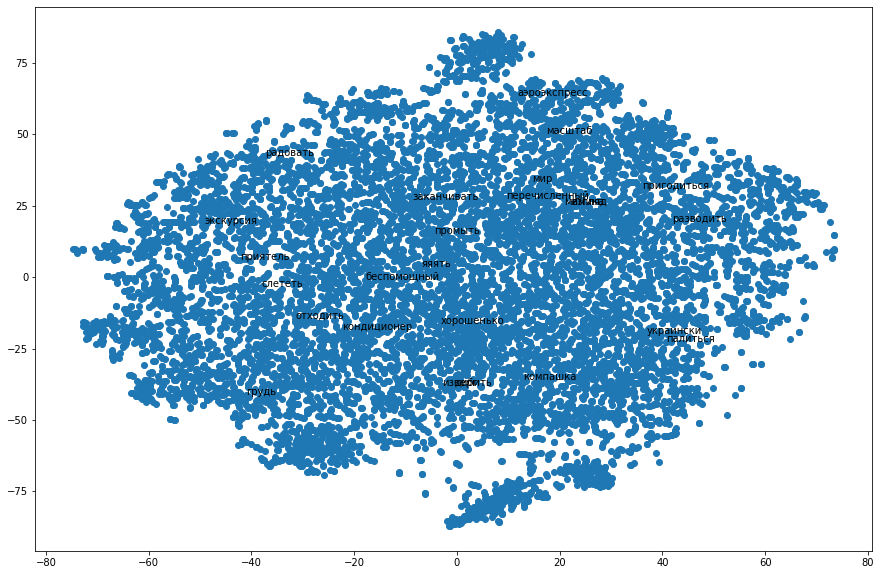

In [179]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (15, 10)


def reduce_dimensions(w2v_model):
    """Фукнция принимает модель word2vec и возвращает массив абсцисс,
    массив ординат и массив слов после снижения размерности"""
    tsne = TSNE(n_components=2, random_state=256)  # создадим экземпляр модели TSNE
    vectors = np.asarray(w2v_model.wv.vectors)     # возьмем из модели 300-мерный массив слов-векторов
    labels = np.asarray(w2v_model.wv.index2word)   # отдельно сохраним соответствие номера вектора и самого слова
    vectors = tsne.fit_transform(vectors)          # проведем преобразование каждого вектора в 2-мерный

    x = [v[0] for v in vectors]                    # запишем отдельно массив абсцисс и массив ординат
    y = [v[1] for v in vectors]
    return x, y, labels


def plot_w2v(w2v_model):
    """Функция строит график распределения слов по векторному пространству
    размерности 2 исходя из обученной модели word2vec"""
    x, y, labels = reduce_dimensions(w2v_model)                      # получим значения по осям и названия точек (исходные слова)
    plt.scatter(x, y)                                                # строим график с точками
    words_to_show_indices = np.random.randint(len(labels), size=25)  # выберем 25 случайных слов, которые отобразим на графике
    for i in words_to_show_indices:
        plt.annotate(labels[i], (x[i], y[i]))                        # для каждого из этих 25 слов отобразим текст на картинке


plot_w2v(w2v)                                                        # применим написанные функции к обученной модели

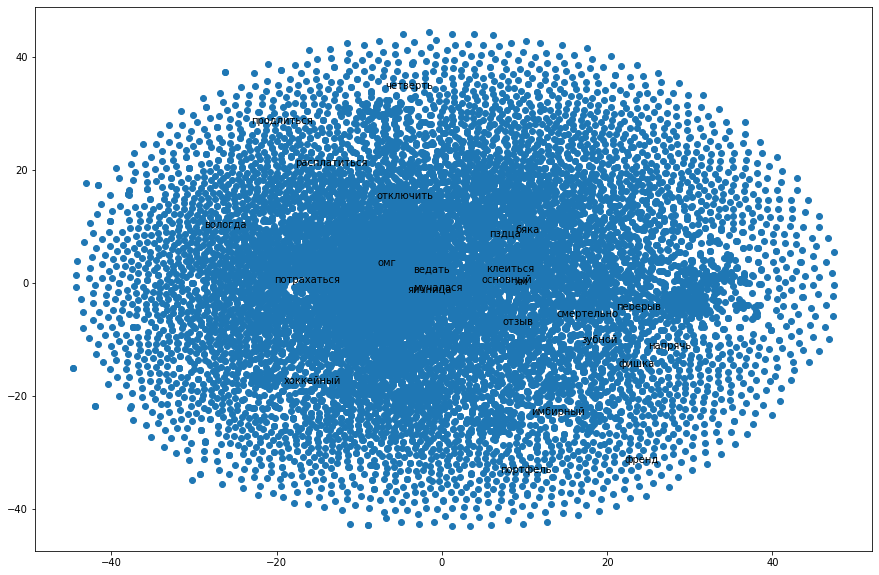

In [191]:
plot_w2v(w2v300)                                                        # применим написанные функции к обученной модели

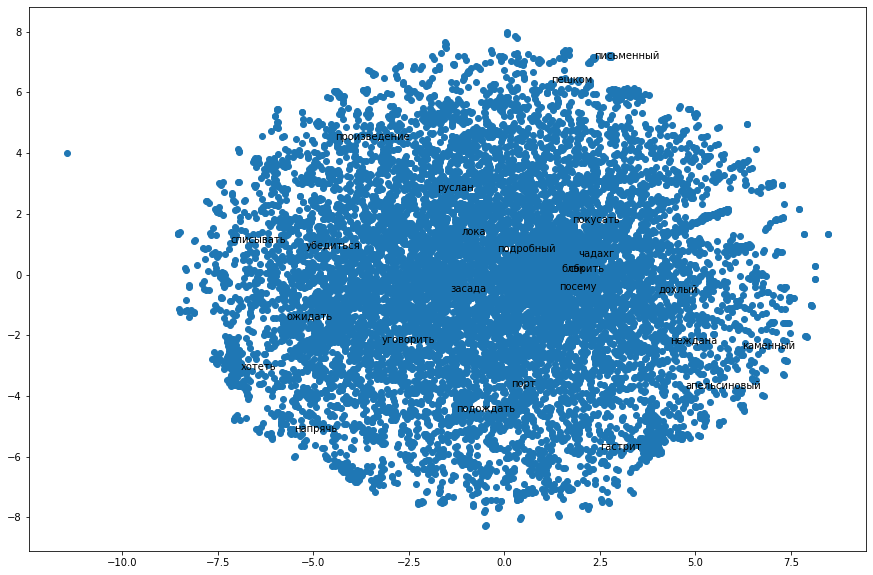

In [196]:
plot_w2v(w2v500)                                                        # применим написанные функции к обученной модели

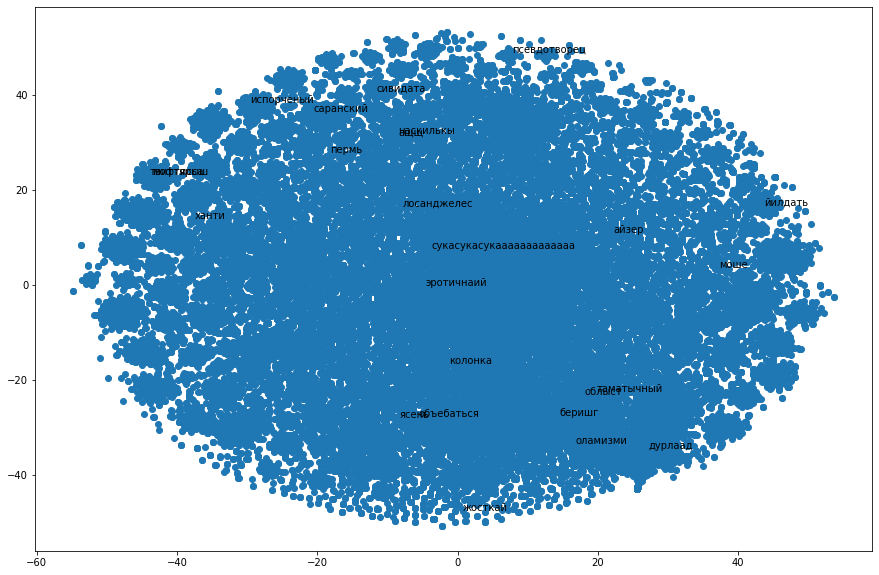

In [200]:
plot_w2v(w2v300_1)

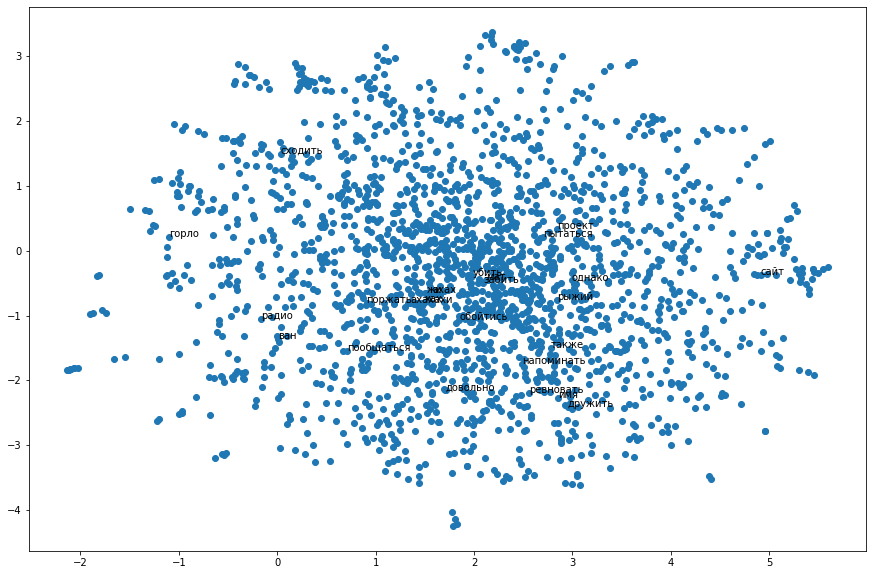

In [202]:
plot_w2v(w2v300_100)

Размер результирующего пространства увеличивает точность определения синонимов/антонимов моделью, за счет увеличения векторного пространства

Предскажем продолжение твита:

In [197]:
# Возьмем один из твитов из датасета
print(df.text[10777])
# Разобьем на отдельные слова в начальной форме
words_tweet = text_preprocessing(df.text[10777])
print(words_tweet)

RT @Partyhard78: Мы с Лизой просто танцевали,чтобы согреться.Но нам сказали,что это было забавно)
['лиза', 'просто', 'танцевать', 'согреться', 'сказать', 'это', 'забавно']


In [198]:
# w2v.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=10000)
w2v.predict_output_word(words_tweet)

[('мама', 0.000567647),
 ('парень', 0.00055853464),
 ('никто', 0.0005187251),
 ('мальчик', 0.00048614986),
 ('подруга', 0.0004855902),
 ('дура', 0.0004740296),
 ('девочка', 0.00045776885),
 ('девка', 0.00044022963),
 ('папа', 0.00042526866),
 ('говорить', 0.00042020378)]

In [199]:
# продолжение случайной фразы
words_tweet = ['Погода', 'сегодня', 'пасмурный']
w2v.predict_output_word(words_tweet)

[('домой', 0.0013410413),
 ('завтра', 0.0012382772),
 ('суббота', 0.0011979017),
 ('воскресение', 0.0011465704),
 ('школа', 0.0010715191),
 ('выходной', 0.0010677599),
 ('вечер', 0.0010292745),
 ('понедельник', 0.0010236277),
 ('провести', 0.0010035614),
 ('каникулы', 0.0009808531)]

Вообще говоря, списки синонимов и антонимов у нас получились достаточно спорные. Причина этого - малая выборка слов, на которых обучалась модель.

# Задание 2

В этом задании от вас требуется провести классификацию текстов с использованием градиентного бустинга. Постройте такую модель, которая даст наилучший результат по метрике precision к классу 0, подобрав гиперпараметры:
- минимальная встречаемость слова в текстах в doc2vec
- максимальная глубина деревеьев в бустинге
- количество деревьев в бустинге

Дайте ответ на вопрос: лучше использовать более глубокие или более мелкие деревья в модели градиентного бустинга?

# 2. Использование градиентного бустинга над решающими деревьями для решения задачи классификации текстов

В предыдущем разделе мы научились превращать слова в векторы. Но перед нами стоит задача классификации текста, а не одного слова, поэтому нам нужно придумать способ, как целый текст представить числами.

После преобразования отдельные слова стали векторами, значения которых зависят от семантики слова. Будем рассматривать твит как сущность с усредненной семантикой всех содержащихся в нём слов. Таким образом, для преобразования целого текста в вектор, нам нужно получить средний вектор всех содержащихся в нём слов. Такой способ реализован в модели Doc2Vec в библиотеке gensim.

In [203]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_df.text)]  # преобразуем наши тексты в объекты, понятные док-2-веку
d2v = Doc2Vec(tweets, min_count=2)                        # создадим модель Doc2Vec
d2v.train(tweets, total_examples=len(tweets), epochs=20)  # подберем веса коэффициентов внутри модели, которые больше будут подходить к нашему набору текстов

In [204]:
from sklearn.model_selection import train_test_split

# разобьем набор текстов на тренировочную и тестовую выборки
X_train_texts, X_test_texts, y_train, y_test = train_test_split(preprocessed_df.text, preprocessed_df.positive, test_size=0.2, random_state=21)

In [205]:
X_train_texts  # пока что наши тексты выглядят как списки слов в начальной форме, но нам нужно получить из этого векторы

114468    [спасибо, григорчук, победа, черноморец, прост...
115015    [проверять, сеня, больничка, хороший, чувствов...
147222          [тухнуть, история, павлух, прийти, сказать]
119060    [ходить, водка, час, это, обработать, правда, ...
74753                                    [похоже, заметить]
                                ...                        
81968     [добавить, фотография, альбом, дело, гулять, с...
140036    [весь, писать, пиздец, происходить, неделя, сп...
202552    [ооо, чувак, понимать, жить, однокомнатный, кв...
70863     [родитель, защищать, свой, говно, ахахах, клас...
80841     [мелкий, коллекция, фишка, весь, покемонама, в...
Name: text, Length: 181467, dtype: object

In [206]:
def transform_text_array_to_vector_dataframe(text_array):
    """Функция, которая преобразует одномерный колонку списков слов из текстов
    в датафрейм со значениями векторов этих текстов"""
    columns = [str(n) for n in range(d2v.vector_size)]               # задаем список названий колонок - просто порядковые номера
    vectors_ndarray = text_array.apply(d2v.infer_vector).to_list()  # прогоняем каждый текст через модель doc2vec и формируем многомерный массив чисел
    return pd.DataFrame(vectors_ndarray, columns=columns)            # оборачиваем его в датафрейм для удобства


X_train = transform_text_array_to_vector_dataframe(X_train_texts)    # наконец создадим датафреймы, которые сможем подать в модель классификации
X_test = transform_text_array_to_vector_dataframe(X_test_texts)

Вы уже познакомились с некоторыми "деревянными" методами машинного обучения - решающим деревом и случайным лесом. Градиентный бустинг - это итеративный способ построения классификации, полученный (как и случайный лес) путем комбинации нескольких алгоритмов. Сначала строится обычное решающее дерево. Затем строится ряд моделей, предсказывающих ошибку исходной модели. Эти предсказания вычитаются из исходной модели. Таким образом, в итоге мы имеем один классификатор, но намного более точный, чем обычное решающее дерево. Чем больше итераций этого алгоритма будет проведено, тем выше получится качество модели, но она будет дольше обучаться.

Градиентный бустинг над решающими деревьями - это, пожалуй, самая распространенная на сегодняшний день модель машинного обучения. Ее используют для решениях многих задач, начиная кредитным скорингом и заканчивая товарным спросом и антифродом. Мы будем использовать эту модель для классификации наших текстов.

Модель градиентного бустинга есть в библиотеке sklearn, но на больших данных она будет обучаться долго. На рынке сейчас популярны несколько оптимизированных реализаций градиентного бустинга. Самые известные - xgboost, lightgbm и catboost. Рассмотрим xgboost, но вы можете использовать любую из этих трех.

In [207]:
# установим библиотеку
!pip install xgboost

Работать с моделью xgboost можно так же, как с моделями sklearn: fit и predict. Основные гиперпараметры - максимальная глубина деревьев модели и количество деревьев.

In [208]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=10, n_estimators=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.64      0.63      0.63     22577
           1       0.64      0.64      0.64     22790

    accuracy                           0.64     45367
   macro avg       0.64      0.64      0.64     45367
weighted avg       0.64      0.64      0.64     45367



In [209]:
xgb = XGBClassifier(max_depth=5, n_estimators=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.62      0.61      0.62     22536
           1       0.62      0.63      0.62     22831

    accuracy                           0.62     45367
   macro avg       0.62      0.62      0.62     45367
weighted avg       0.62      0.62      0.62     45367



При уменьшении глубины с 10 до 5 метрики качества ухудшаются.
